In [60]:
from pyawd import VectorAcousticWaveDataset2D, VectorAcousticWaveDataset3D
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
from time import time
import torch
from torchinfo import summary

torch.manual_seed(0)
sns.set_theme()

In [61]:
device = 'cpu'
torch.set_default_device(device)

In [62]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    def __len__(self):
        return len(self.X)

In [63]:
def normalize(X):
    max_X = np.max(X)
    min_X = np.min(X)
    return (X-min_X)/(max_X-min_X)

In [64]:
train_dataset = VectorAcousticWaveDataset2D.load("../../../local/datasets/AWD/train_small2D")
train_dataset._display_velocity_model = True
X = np.load("../../../local/datasets/AWD/train_small2D_interrogators_data.npy")
X = normalize(X)
Y = np.load("../../../local/datasets/AWD/train_small2D_epicenters.npy")
Y = normalize(Y)
test_dataset = VectorAcousticWaveDataset2D.load("../../../local/datasets/AWD/test_small2D")
test_dataset._display_velocity_model = True
X_test = np.load("../../../local/datasets/AWD/test_small2D_interrogators_data.npy")
X_test = normalize(X_test)
Y_test = np.load("../../../local/datasets/AWD/test_small2D_epicenters.npy")
Y_test = normalize(Y_test)

In [65]:
print(X.shape)

(2500, 1, 2, 2, 1000)


In [67]:
train = CustomDataset(X, Y)
train_loader = torch.utils.data.DataLoader(train, batch_size=10)

test = CustomDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test, batch_size=10)

In [68]:
def NMSELoss(y, y_hat):
    return np.square(np.subtract(y, y_hat)).mean()/np.var(y)

In [69]:
def train_loop(loader, model, loss_fn, optimizer, scheduler):
    model.train()
    for x, y in loader:
        pred = model(x)
        loss = loss_fn(pred.squeeze(1), y.squeeze(1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    scheduler.step()

def test_loop(model, loader):
    model.eval()
    loss = 0
    for x, y in loader:
        pred = model(x)
        loss += loss_fn(pred.squeeze(1), y.squeeze(1)).item()
    return loss/len(X)      

In [77]:
def rmse(y, y_hat):
    return torch.mean((y-y_hat)**2)**0.5

In [81]:
class FFN(torch.nn.Module):
    def __init__(self):
        super(FFN, self).__init__()

        self.linear1 = torch.nn.Linear(X[0].shape[-1], 250)
        self.activation = torch.nn.Tanh()
        self.linear2 = torch.nn.Linear(250, 100)
        self.flatten = torch.nn.Flatten()
        self.linear3 = torch.nn.Linear(np.prod(X[0].shape[:-1])*100, 2)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.flatten(x)
        x = self.linear3(x)
        x = self.activation(x)
        return x.double()

model = FFN()
learning_rate = 5e-5
epochs = 100
loss_fn = rmse
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.9)
losses = []

In [82]:
summary(model)

Layer (type:depth-idx)                   Param #
FFN                                      --
├─Linear: 1-1                            250,250
├─Tanh: 1-2                              --
├─Linear: 1-3                            25,100
├─Flatten: 1-4                           --
├─Linear: 1-5                            802
Total params: 276,152
Trainable params: 276,152
Non-trainable params: 0

In [83]:
t = time()
for e in (pbar := tqdm(range(epochs))):
    train_loop(train_loader, model, loss_fn, optimizer, scheduler)
    losses.append(test_loop(model, test_loader))
    pbar.set_description("Loss: " + str(losses[-1])[:8])
t = time()-t

  0%|          | 0/100 [00:00<?, ?it/s]

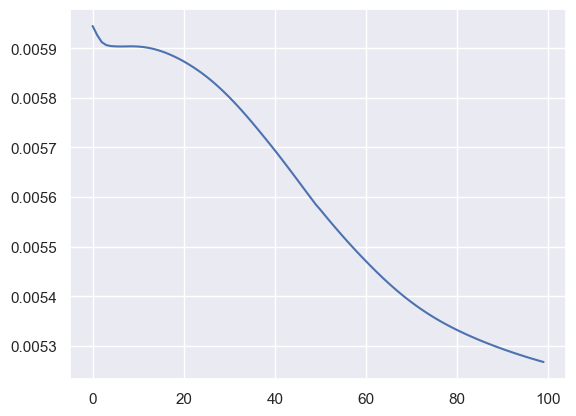

In [84]:
plt.plot(losses)
plt.savefig("../Results/FFN_learning.jpg", dpi=250)

RMSE: tensor(0.2655, dtype=torch.float64)


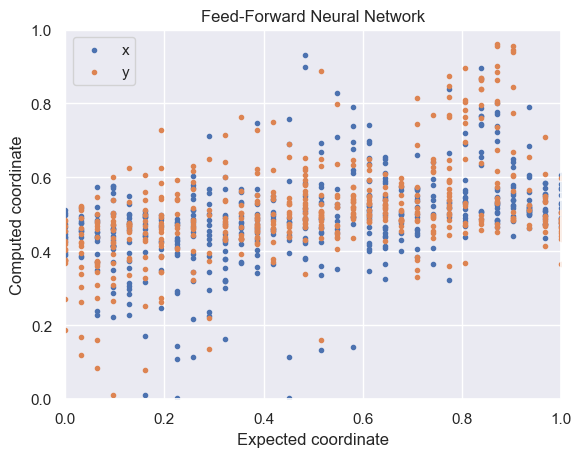

In [89]:
y_test = np.array([(i[0].item(), i[1].item()) for i in Y_test])
y_hat = np.array([model.forward(torch.Tensor(i).unsqueeze(0)).detach().numpy() for i in X_test])
y_hat = np.array([(i[:, 0].item(), i[:, 1].item()) for i in y_hat])
rmse = rmse(torch.Tensor(y_test), y_hat)
print("RMSE:", rmse)
plt.scatter(y_test[:, 0], y_hat[:, 0], marker='.')
plt.scatter(y_test[:, 1], y_hat[:, 1], marker='.')
plt.legend(["x", "y"])
plt.xlabel("Expected coordinate")
plt.ylabel("Computed coordinate")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("Feed-Forward Neural Network")
plt.savefig("../Results/FFN.jpg", dpi=250)

In [86]:
with open("../Results/results.csv", 'a') as f:
    f.write("FNN" + "," + str(nmse)[:7] + "," + str(t)[:7] + "," + str(nmse*t)[:7] + "\n")

In [87]:
i = 0
print("Expected epicenter:", test_dataset.get_epicenter(i))
print("\t- FFN:\t\t", y_hat[i])

Expected epicenter: [-0.8125 -0.1875]
	- FFN:		 [0.28646541 0.62048978]
